Banco de dados com valores de alugueis de imóveis de 5 cidades brasileiras: São Paulo, Rio de Janeiro, Belo Horizonte, Porto Alegre e Campinas.

Fazer a predição dos valores através de modelos que utilizam regressão.

**Aconselho vizualisar no Google Colab, pois há tópicos.**

Fonte: https://www.kaggle.com/datasets/fabiobarreto/imoveis-aluguel

# **Importando os dados e fazendo breve análise**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

%matplotlib inline

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [117]:
df = pd.read_csv("casas_aluguel.csv")

In [118]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


**Verificando se há dados nulos**

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


**Verificando se há dados duplicados**

In [120]:
df.duplicated().sum()

358

Excluindo...

In [121]:
df.drop_duplicates(inplace=True)

**Como visto na análise dos dataset, há dados preenchidos por "-" no lugar dos valores não preenchidos, vamos preencher por NaN para tratamento dentro do modelo.**

In [122]:
df["floor"].replace("-", np.nan, inplace=True)

**Verificando...**

In [123]:
df["floor"].value_counts()

1      1000
2       952
3       895
4       727
5       580
6       530
7       488
8       486
9       360
10      352
11      296
12      255
13      195
14      168
15      143
16      108
17       95
18       74
19       53
20       43
21       42
22       24
23       23
25       19
24       18
26       13
27        8
28        5
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

**Agora há 2.461 dados nulos na variável "floor". É considerado muito para 10.334 dados. Em vez de retirá-las, vamos tratá-las durante o processo.**

In [124]:
df.isna().sum()

city                      0
area                      0
rooms                     0
bathroom                  0
parking spaces            0
floor                  2371
animal                    0
furniture                 0
hoa (R$)                  0
rent amount (R$)          0
property tax (R$)         0
fire insurance (R$)       0
total (R$)                0
dtype: int64

**Percemos alguns outliers que podem prejudicar no andamento dos modelos, como são poucos vamos retirá-los.**

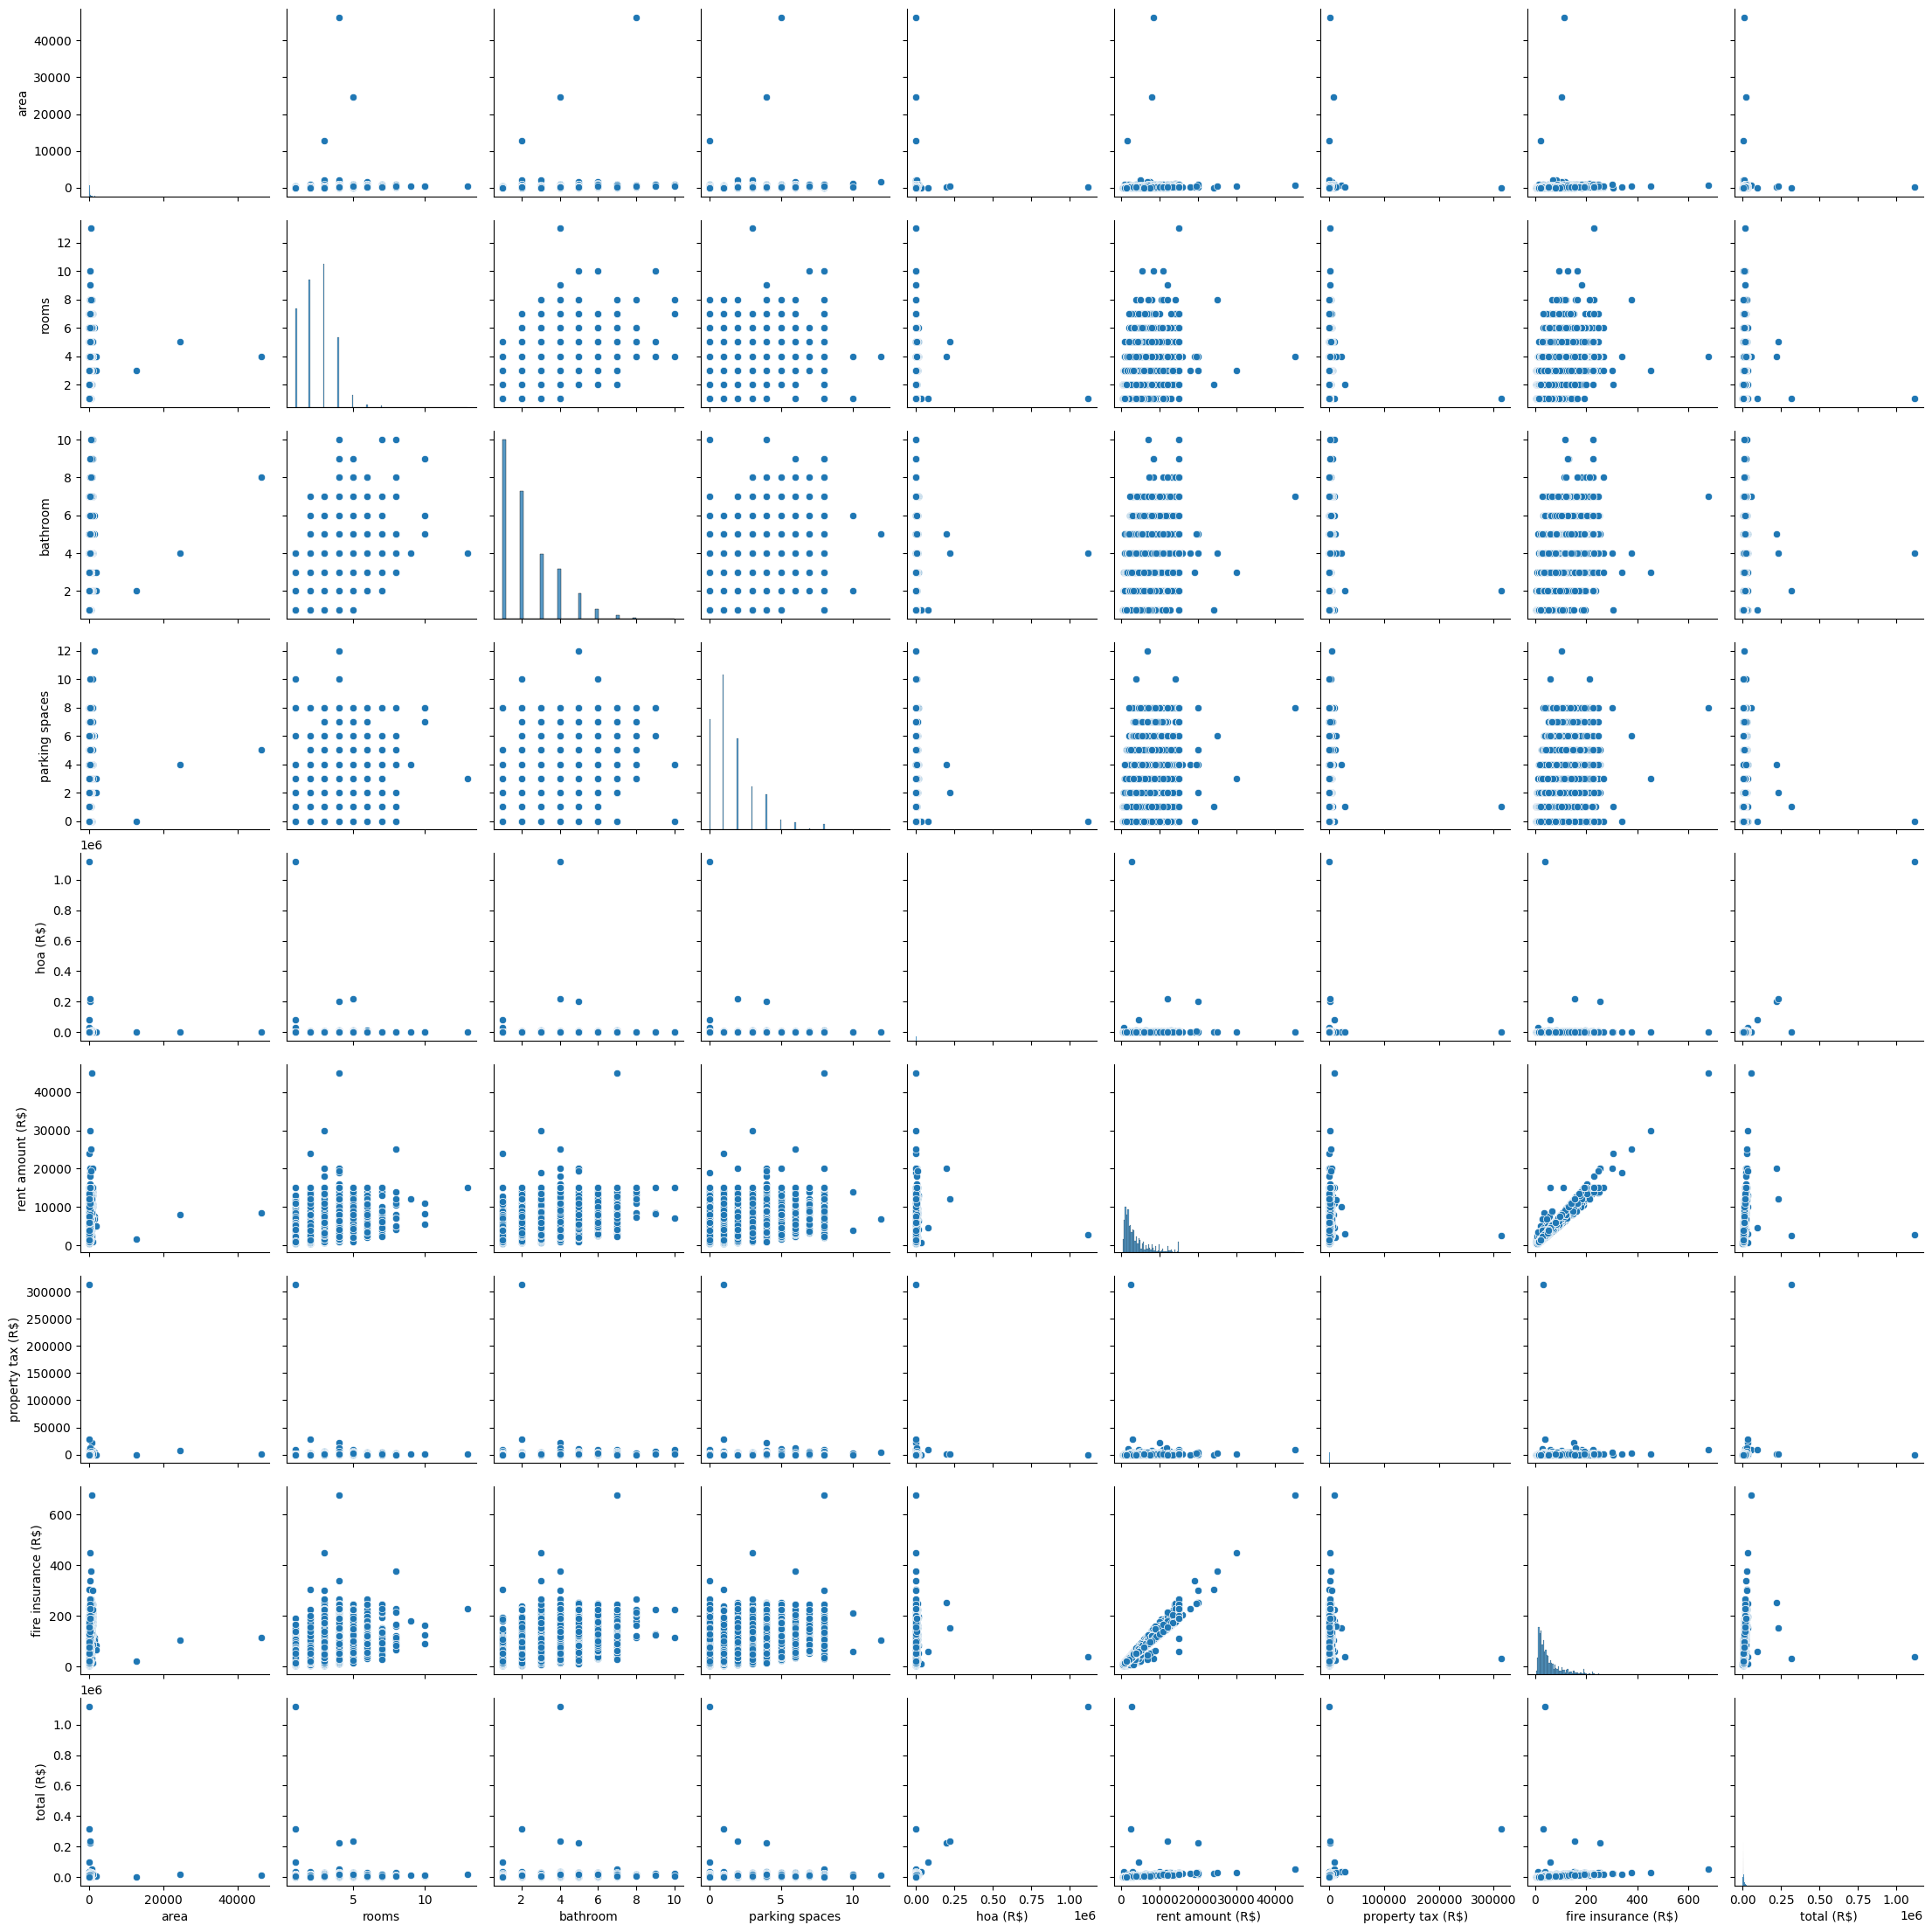

In [10]:
sns.pairplot(df);

# **KNN Regressor**

**O KNN é um estimador onde o aprendizado é baseado “no quão similar” é um dado (um vetor) do outro. Como estamos tratando de regressão, talvez ele não seja válido, mas vamos testar.**

**Vamos substituir os dados nulos pela palavra "unknown" para não precisarmos deletar os 2.461 dados nulos. Fazendo essa substituição, deixamos claro que os dados não são conhecidos, entretando fica melhor para rodar nos modelos.**

In [125]:
imputer = SimpleImputer(missing_values = np.nan, strategy ='constant', fill_value="unknown")
imputer = imputer.fit(df[["floor"]])
    
df["floor"] = imputer.transform(df[["floor"]])

**Vamos agora transformar as variáveis categóricas em numéricas, pois os estimadores só modelam dados numéricos.**

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [126]:
lista_ohe = ["furniture", "animal"]

for i in lista_ohe:  
  ohe =  OrdinalEncoder()
  ohe.fit(df[[i]])

  df[i]= ohe.transform(df[[i]])

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [127]:
lista_oe = ["city", "floor"] # Passei o "floor" por que ele contém o "unknown" que é categórica.

for i in lista_oe:  
  oe =  OrdinalEncoder()
  oe.fit(df[[i]])

  df[i]= oe.transform(df[[i]])

**Verificando a transformação. Perceba que as 3 variáveis (colunas) que tinham dados categóricos passaram para numéricos.**

In [128]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,4.0,70,2,1,1,31.0,0.0,0.0,2065,3300,211,42,5618
1,4.0,320,4,4,0,12.0,0.0,1.0,1200,4960,1750,63,7973
2,2.0,80,1,1,1,30.0,0.0,1.0,1000,2800,0,41,3841
3,2.0,51,2,1,0,11.0,0.0,1.0,270,1112,22,17,1421
4,4.0,25,1,1,0,0.0,1.0,1.0,0,800,25,11,836


**Agora vamos escalonar todos os dados para ficarem com dimensões próximas.**

In [20]:
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [129]:
ssc = StandardScaler()

ssc.fit(df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
h= ssc.transform(df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)', 'property tax (R$)', 'fire insurance (R$)']] = h

**Vericando...todos os dados escalonados!!**

In [65]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.749777,-0.151030,-0.462248,-0.896891,-0.403187,0.796914,-0.528766,-1.763220,0.085077,-0.193915,-0.052502,-0.254646,5618
1,0.749777,0.306972,1.249892,1.223878,-1.028793,-0.679505,-0.528766,0.567144,0.009502,0.289202,0.434454,0.181382,7973
2,-0.653373,-0.132710,-1.318318,-0.896891,-0.403187,0.719208,-0.528766,0.567144,-0.007972,-0.339432,-0.119264,-0.275409,3841
3,-0.653373,-0.185838,-0.462248,-0.896891,-1.028793,-0.757212,-0.528766,0.567144,-0.071752,-0.830697,-0.112303,-0.773727,1421
4,0.749777,-0.233470,-1.318318,-0.896891,-1.028793,-1.611981,1.891194,0.567144,-0.095342,-0.921500,-0.111354,-0.898306,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.653373,-0.163854,-0.462248,-0.896891,-0.403187,0.563796,1.891194,-1.763220,-0.060219,-0.724179,-0.111671,-0.669911,1926
10688,0.749777,0.242852,1.249892,1.223878,1.473631,-0.990330,-0.528766,0.567144,0.175506,3.211184,0.188603,2.839076,19260
10689,0.048202,-0.151030,0.393822,0.516955,-1.028793,0.874621,1.891194,-1.763220,-0.009719,0.591877,-0.014216,0.492830,7390
10690,0.048202,-0.059429,-0.462248,-0.189968,0.222419,0.874621,-0.528766,-1.763220,0.043140,2.338082,-0.030986,2.091600,14020


**Chamando o KNN...**

In [23]:
knn = KNeighborsRegressor()

**Fazendo a grade de parâmetros do KNN**

In [72]:
param_grid_knn = {"weights" : ["uniform", "distance"],
                 "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"],
                 "n_neighbors" : range(2, 21)}

**Vamos jogar para 10 splits**

In [73]:
splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

**Separando os dados de treino com os dados de teste.**

In [74]:
X = df.drop(columns=["total (R$)"])
y = df["total (R$)"]

# Dividindo em dados de teste e dados de treino, peguei 30% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

**Motando a grade geral dos parâmetros com o GridSearch**

In [75]:
model_knn = GridSearchCV(estimator=knn,
                       param_grid=param_grid_knn ,
                       scoring="r2", 
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1,
                       refit="recall")

model_knn.fit(X_train, y_train)

Fitting 10 folds for each of 152 candidates, totalling 1520 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(2, 21),
                         'weights': ['uniform', 'distance']},
             refit='recall', scoring='r2', verbose=10)

In [76]:
model_knn.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'distance'}

**Overfitou os dados de treino no KNN, vamos seguir com outros estimadores para ver se conseguimos melhoras.**

In [77]:
# Predições de treino
y_pred_train_knn = model_knn.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train_knn):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_knn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_knn)):.2f}")

# Predições de teste
y_pred_test_knn = model_knn.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test_knn):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_knn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_knn)):.2f}") 


Métricas de treino:

R^2: 1.00
MAE: 0.00
RMSE: 0.00

Métricas de teste:

R^2: 0.94
MAE: 677.44
RMSE: 1112.77


In [78]:
tabela_knn = pd.DataFrame()

In [79]:
tabela_knn["Amostra existente"] = y_test

In [80]:
tabela_knn["Predição"] = y_pred_test_knn

In [243]:
tabela_knn["porcentagem de acerto %"]= (y_test/y_pred_test_knn)*100

In [244]:
lista_num = []
for c in tabela_knn["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela_knn["porcentagem de acerto %"]= lista_num

In [245]:
tabela_knn

,Amostra existente,Predição,porcentagem de acerto %
6856,2294,1256.987885,17.500230
3032,14560,12974.787126,87.782359
913,2309,2411.732076,95.740320
5853,1647,1905.040449,86.454857
3725,2650,2770.497477,95.650692
...,...,...,...
7933,6118,5190.731588,82.136075
157,26800,21509.319597,75.402846
6912,1573,1571.388493,99.897447
2880,8106,7795.706806,96.019691


Salvando a tabela

In [246]:
tabela_knn.to_csv("01-knn_tabela_comparação.csv")

Salvando o estimador...

In [11]:
import joblib

In [83]:
joblib.dump(model_knn, 'knn_modelo.pkl')

['knn_modelo.pkl']

In [12]:
knn_modelo = joblib.load('knn_modelo.pkl')

#**XGBoost Regressor**

**Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:**

In [284]:
X = df.drop(columns="total (R$)")
y = df["total (R$)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

**Chamando o XGBoost Regressor...**

In [131]:
xgbr = XGBRegressor(eval_metric='logloss', random_state=42)

**Fazendo a grade de parâmetros do XGBoost Regressor**

In [229]:
params_grid_xgbr = {"n_estimators": [400],
                   "max_depth": [2, 3],
                   "learning_rate": [0.01]} 


**Vamos jogar para 5 splits**

In [133]:
splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

**Motando a grade geral dos parâmetros com o GridSearch**

In [230]:
model_xgbr = GridSearchCV(estimator=xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2", 
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

model_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='logloss', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [2, 3],
                         'n_estimators': [400]},
             scoring='r2', verbose=10)

**Vamos comparar as métricas de treino com as medições de teste.**

**Ótimo resultado, com um gap de apenas 3% entre as métricas.**

In [231]:
y_pred_train = model_xgbr.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")


y_pred_test = model_xgbr.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.98
MAE: 536.11
RMSE: 1921.71

Métricas de teste:

R^2: 0.95
MAE: 518.82
RMSE: 962.92


In [232]:
model_xgbr.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}

Tabela de forma decrescente com as melhores métricas.

In [233]:
xgbr_results = pd.DataFrame(model_xgbr.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.325355,0.075226,0.015929,0.000528,0.01,3,400,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.192621,0.914094,0.938134,0.466712,0.917947,0.685902,0.303614,1
0,2.620994,0.850158,0.027141,0.018112,0.01,2,400,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.094702,0.720343,0.818739,0.442833,0.909874,0.597298,0.296088,2


**Salvando o estimador...**

In [ ]:
import joblib

In [234]:
joblib.dump(model_knn, 'xgbr_modelo.pkl')

['xgbr_modelo.pkl']

In [ ]:
xgbr_modelo = joblib.load('xgbr_modelo.pkl')

**Vamos agora fazer uma breve comparação entre os dados originais e os preditos.**

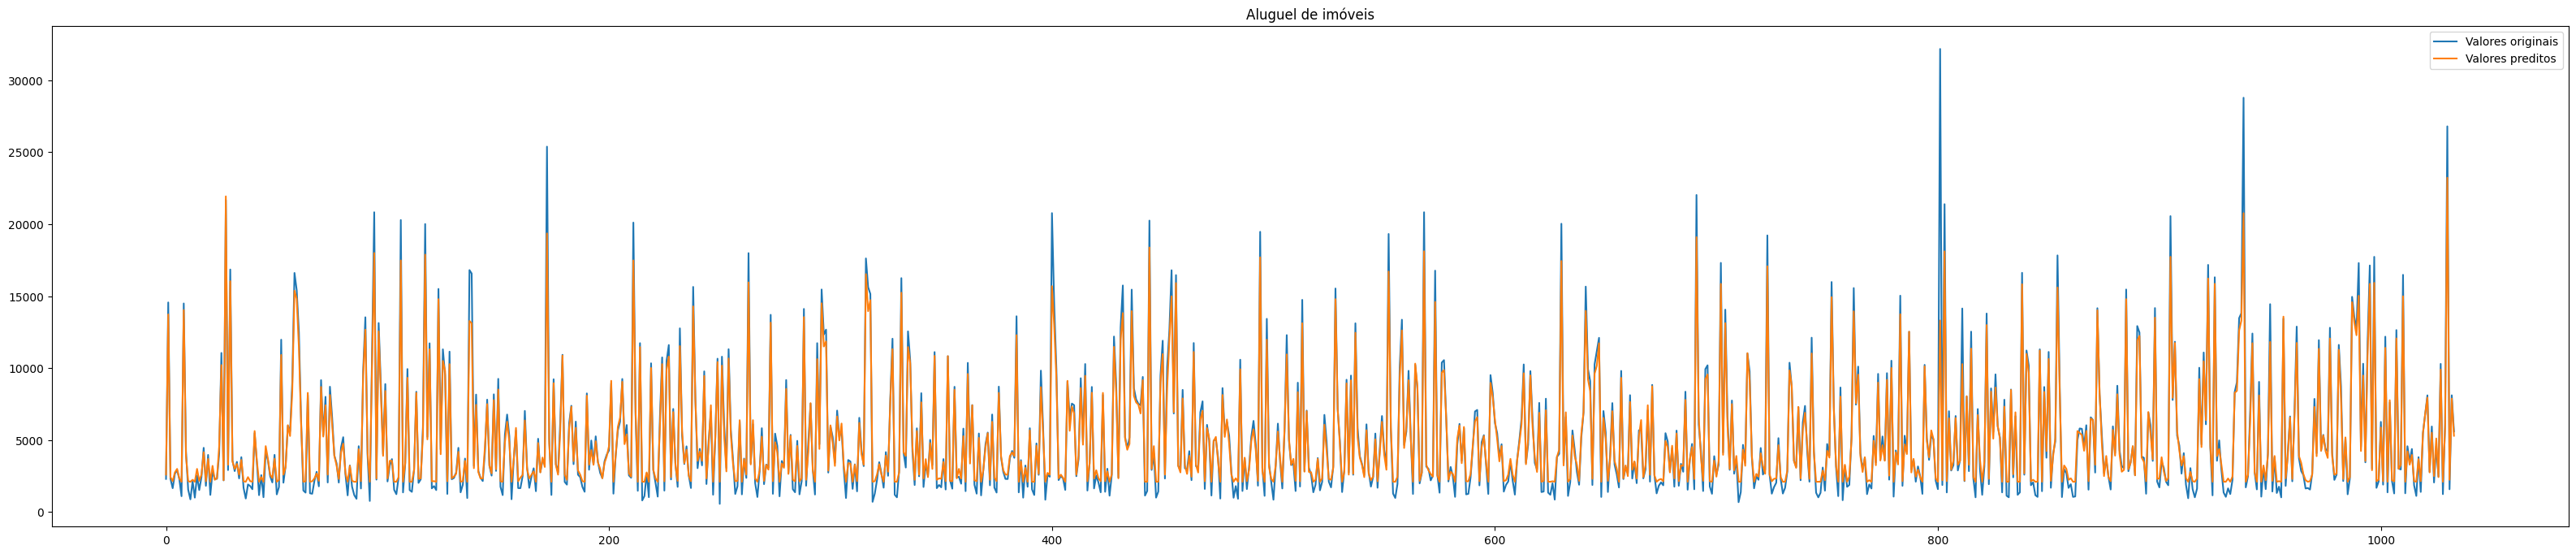

In [235]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores originais")
plt.plot(x_ax, y_pred_test, label="Valores preditos")
plt.title("Aluguel de imóveis")
plt.legend()
plt.show();

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [236]:
tabela = pd.DataFrame()

In [237]:
tabela["valores reais"] = y_test

In [238]:
tabela["valores preditos"] = y_pred_test

In [239]:
tabela["porcentagem de acerto %"]= (y_test/y_pred_test)*100

In [240]:
lista_num = []
for c in tabela["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela["porcentagem de acerto %"]= lista_num

In [241]:
tabela

,valores reais,valores preditos,porcentagem de acerto %
6856,2294,2591.685303,88.513833
3032,14560,13727.763672,93.937568
913,2309,2418.669678,95.465703
5853,1647,2135.822510,77.113149
3725,2650,2743.976074,96.575186
...,...,...,...
7933,6118,5823.104004,94.935759
157,26800,23229.074219,84.627344
6912,1573,2231.705811,70.484201
2880,8106,7875.757812,97.076571


In [242]:
tabela.to_csv("01-aluguelDeCasas_resultado_xgbr.csv")

# **Otimização Bayesiana**

**Utiliza o processo gaussiano. Vamos utlizar para tentar melhorar a acurácia**.



---



---



---



In [300]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.749777,-0.151030,-0.462248,-0.896891,-0.403187,0.796914,-0.528766,-1.763220,0.085077,-0.193915,-0.052502,-0.254646,5618
1,0.749777,0.306972,1.249892,1.223878,-1.028793,-0.679505,-0.528766,0.567144,0.009502,0.289202,0.434454,0.181382,7973
2,-0.653373,-0.132710,-1.318318,-0.896891,-0.403187,0.719208,-0.528766,0.567144,-0.007972,-0.339432,-0.119264,-0.275409,3841
3,-0.653373,-0.185838,-0.462248,-0.896891,-1.028793,-0.757212,-0.528766,0.567144,-0.071752,-0.830697,-0.112303,-0.773727,1421
4,0.749777,-0.233470,-1.318318,-0.896891,-1.028793,-1.611981,1.891194,0.567144,-0.095342,-0.921500,-0.111354,-0.898306,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.653373,-0.163854,-0.462248,-0.896891,-0.403187,0.563796,1.891194,-1.763220,-0.060219,-0.724179,-0.111671,-0.669911,1926
10688,0.749777,0.242852,1.249892,1.223878,1.473631,-0.990330,-0.528766,0.567144,0.175506,3.211184,0.188603,2.839076,19260
10689,0.048202,-0.151030,0.393822,0.516955,-1.028793,0.874621,1.891194,-1.763220,-0.009719,0.591877,-0.014216,0.492830,7390
10690,0.048202,-0.059429,-0.462248,-0.189968,0.222419,0.874621,-0.528766,-1.763220,0.043140,2.338082,-0.030986,2.091600,14020


In [338]:
X = df.drop(columns="total (R$)")
y = df["total (R$)"]

X_train_ob, X_test_ob, y_train_ob, y_test_ob = train_test_split(X, y, test_size=0.1, random_state=13)

In [ ]:
!pip install hyperopt
from six.moves import collections_abc
from hyperopt import hp, tpe, fmin, Trials, space_eval

**Vamos utilizar os mesmo parâmetros do XGBoost, já que até agora foi a que deu melhor acurácia.**

In [340]:
hps_space = {"n_estimators" : hp.choice("n_estimators",  range(300, 1000)),  
             "max_depth" : hp.choice("max_depth", range(2, 11)),
             "learning_rate" : hp.choice("learning_rate", [0.001, 0.01])}

In [303]:
from sklearn.model_selection import cross_validate

In [313]:
splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [341]:
def objective(hps_space):
    
    pipe =  XGBRegressor(**hps_space)
    # =============================================
    results = cross_validate(pipe,
                             X_train_ob, y_train_ob, 
                             cv=splitter,
                             scoring="r2",
                             n_jobs=-1)

    r2 = results["test_score"].mean()

    # como o valor vai ser minimizado, mas queremos MAXIMIZAR o r2, colocamos esse sinal negativo
    return -r2

In [342]:
ts = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=ts,
                max_evals=10)

100%|██████████| 10/10 [04:30<00:00, 27.01s/trial, best loss: -0.7259257340006945]


In [343]:
# a resposta final, vem com o space_eval
best_hps = space_eval(hps_space, best_hps)
best_hps

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 964}

In [344]:
xgbr_ob = XGBRegressor(**best_hps, use_label_encoder=False)

xgbr_ob.fit(X_train_ob, y_train_ob)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=964, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [345]:
y_pred_train_ob = xgbr_ob.predict(X_train_ob)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train_ob, y_pred_train_ob):.2f}")
print(f"MAE: {mean_absolute_error(y_train_ob, y_pred_train_ob):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train_ob, y_pred_train_ob)):.2f}")


y_pred_test_ob = xgbr_ob.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test_ob, y_pred_test_ob):.2f}")
print(f"MAE: {mean_absolute_error(y_test_ob, y_pred_test_ob):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_ob, y_pred_test_ob)):.2f}") 


Métricas de treino:

R^2: 1.00
MAE: 124.77
RMSE: 240.81

Métricas de teste:

R^2: 0.99
MAE: 140.16
RMSE: 345.82


**Já conseguimos equilibrar mais com otimização Bayesiana:**

In [347]:
probas_y_pred_test_ob = xgbr_ob.predict(X_test_ob)

In [348]:
tabela_xgbc_ob = pd.DataFrame()

In [349]:
y_test_ob.shape, y_pred_test_ob.shape

((1034,), (1034,))

In [350]:
tabela_xgbc_ob["Amostra existente"] = y_test_ob

In [351]:
tabela_xgbc_ob["Predição"] = y_pred_test_ob

In [352]:
tabela_xgbc_ob

,Amostra existente,Predição
6856,2294,2272.809326
3032,14560,14452.647461
913,2309,2258.301514
5853,1647,1619.140381
3725,2650,2522.782959
...,...,...
7933,6118,6154.073730
157,26800,27923.291016
6912,1573,1714.532471
2880,8106,7957.422363


Salvando a tabela

In [ ]:
tabela_xgbc_ob.to_csv("16-inadimplência_xgbc_ob.csv")

Salvando o estimador...

In [ ]:
import joblib

In [ ]:
joblib.dump(pipe, 'xgbc_modelo_ob.pkl')

['xgbc_modelo_ob.pkl']

In [ ]:
xgbc_modelo_ob = joblib.load('xgbc_modelo_ob.pkl')



---



---



---



#**Interpretando o modelo globalmente**

In [247]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.749777,-0.151030,-0.462248,-0.896891,-0.403187,0.796914,-0.528766,-1.763220,0.085077,-0.193915,-0.052502,-0.254646,5618
1,0.749777,0.306972,1.249892,1.223878,-1.028793,-0.679505,-0.528766,0.567144,0.009502,0.289202,0.434454,0.181382,7973
2,-0.653373,-0.132710,-1.318318,-0.896891,-0.403187,0.719208,-0.528766,0.567144,-0.007972,-0.339432,-0.119264,-0.275409,3841
3,-0.653373,-0.185838,-0.462248,-0.896891,-1.028793,-0.757212,-0.528766,0.567144,-0.071752,-0.830697,-0.112303,-0.773727,1421
4,0.749777,-0.233470,-1.318318,-0.896891,-1.028793,-1.611981,1.891194,0.567144,-0.095342,-0.921500,-0.111354,-0.898306,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.653373,-0.163854,-0.462248,-0.896891,-0.403187,0.563796,1.891194,-1.763220,-0.060219,-0.724179,-0.111671,-0.669911,1926
10688,0.749777,0.242852,1.249892,1.223878,1.473631,-0.990330,-0.528766,0.567144,0.175506,3.211184,0.188603,2.839076,19260
10689,0.048202,-0.151030,0.393822,0.516955,-1.028793,0.874621,1.891194,-1.763220,-0.009719,0.591877,-0.014216,0.492830,7390
10690,0.048202,-0.059429,-0.462248,-0.189968,0.222419,0.874621,-0.528766,-1.763220,0.043140,2.338082,-0.030986,2.091600,14020


Percebemos que as features que tem dados como números contínuos tem um maior impacto na interpretação do que as features com dados como números discretos e as features com os maiores valores pesam mais na saída final, se analisarmos no dataset veremos que os valores da feature 'rent amount' são maiores que 'hoa' e assim sucessivamente como vemos no gráfico final:

**SHAP**

In [ ]:
!pip install shap
import shap

**Separar em features e target...**

In [248]:
#Separando o que é features e target:
X = df.drop(columns="total (R$)")
y = df["total (R$)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [249]:
xgbr = XGBRegressor().fit(X_train, y_train)

In [252]:
explainer = shap.TreeExplainer(xgbr)

In [253]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

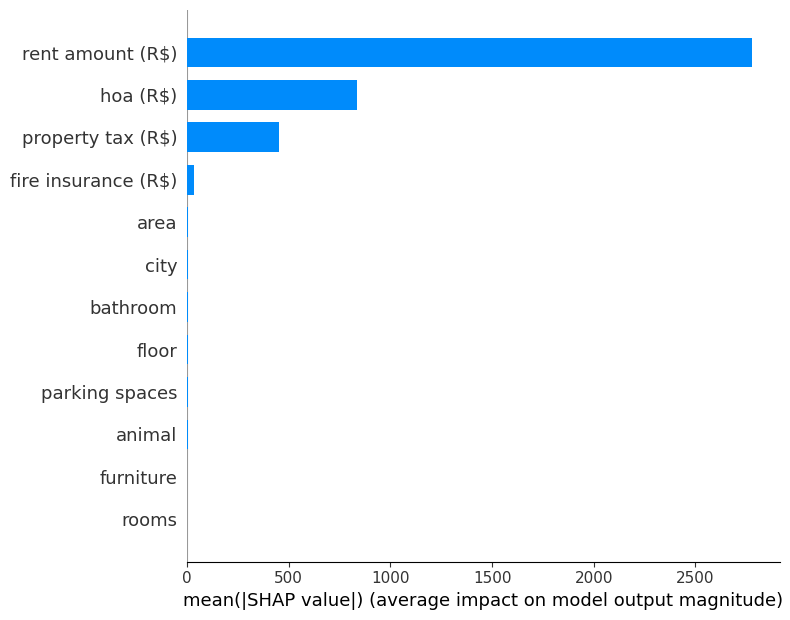

In [254]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")

# **Rede Neural - Keras Regressor**

In [ ]:
!pip install scikeras

In [256]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as k 
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [257]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.749777,-0.151030,-0.462248,-0.896891,-0.403187,0.796914,-0.528766,-1.763220,0.085077,-0.193915,-0.052502,-0.254646,5618
1,0.749777,0.306972,1.249892,1.223878,-1.028793,-0.679505,-0.528766,0.567144,0.009502,0.289202,0.434454,0.181382,7973
2,-0.653373,-0.132710,-1.318318,-0.896891,-0.403187,0.719208,-0.528766,0.567144,-0.007972,-0.339432,-0.119264,-0.275409,3841
3,-0.653373,-0.185838,-0.462248,-0.896891,-1.028793,-0.757212,-0.528766,0.567144,-0.071752,-0.830697,-0.112303,-0.773727,1421
4,0.749777,-0.233470,-1.318318,-0.896891,-1.028793,-1.611981,1.891194,0.567144,-0.095342,-0.921500,-0.111354,-0.898306,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.653373,-0.163854,-0.462248,-0.896891,-0.403187,0.563796,1.891194,-1.763220,-0.060219,-0.724179,-0.111671,-0.669911,1926
10688,0.749777,0.242852,1.249892,1.223878,1.473631,-0.990330,-0.528766,0.567144,0.175506,3.211184,0.188603,2.839076,19260
10689,0.048202,-0.151030,0.393822,0.516955,-1.028793,0.874621,1.891194,-1.763220,-0.009719,0.591877,-0.014216,0.492830,7390
10690,0.048202,-0.059429,-0.462248,-0.189968,0.222419,0.874621,-0.528766,-1.763220,0.043140,2.338082,-0.030986,2.091600,14020


In [ ]:
X = df.drop(columns=["total (R$)"])
y = df["total (R$)"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [20],
          "kr__epochs":[1000]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr.fit(X_train, y_train)

In [260]:
grid_kr.best_params_

{'kr__batch_size': 20, 'kr__epochs': 1000, 'kr__optimizer': 'adam'}

In [261]:
grid_kr.best_score_

-733.5143269842573

In [266]:
y_pred_keras = grid_kr.predict(X_test)

104/104 [==============================] - 0s 3ms/step


In [267]:
y_pred_keras

array([ 4376.5557, 11644.749 ,  7780.6553, ...,  2985.762 ,  3104.8008,
        8917.061 ], dtype=float32)

In [265]:
tabela_keras = pd.DataFrame()

In [268]:
tabela_keras["Valor real"] = y_test

In [270]:
tabela_keras["Valor preditivo"] = y_pred_keras

In [271]:
tabela_keras["porcentagem de acerto %"]= (y_test/y_pred_keras)*100

In [272]:
lista_num = []
for c in tabela_keras["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela_keras["porcentagem de acerto %"]= lista_num

In [274]:
tabela_keras = tabela_keras.sort_index()
tabela_keras = tabela_keras.reset_index()
tabela_keras

,index,Valor real,Valor preditivo,porcentagem de acerto %
0,0,5618,4937.702148,86.222380
1,3,1421,1343.088379,94.199070
2,8,16440,14625.994141,87.597384
3,10,2747,2366.291992,83.911199
4,14,5343,4692.202637,86.130237
...,...,...,...,...
2062,10666,3489,3020.424072,84.486419
2063,10681,16040,14253.883789,87.469266
2064,10685,8726,7712.821289,86.863708
2065,10690,14020,12458.284180,87.464439


In [278]:
tabela_keras.to_csv("01-aluguelDeCasas_resultado_keras.csv")

In [275]:
lista = []
for c in range(tabela_keras.shape[0]):
  if tabela_keras.loc[[c]].values[0][2] < tabela_keras.loc[[c]].values[0][1]:
      valor = (tabela_keras.loc[[c]].values[0][2] / tabela_keras.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela_keras.loc[[c]].values[0][2] > tabela_keras.loc[[c]].values[0][1]:
      valor = (tabela_keras.loc[[c]].values[0][1] / tabela_keras.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 86.60%


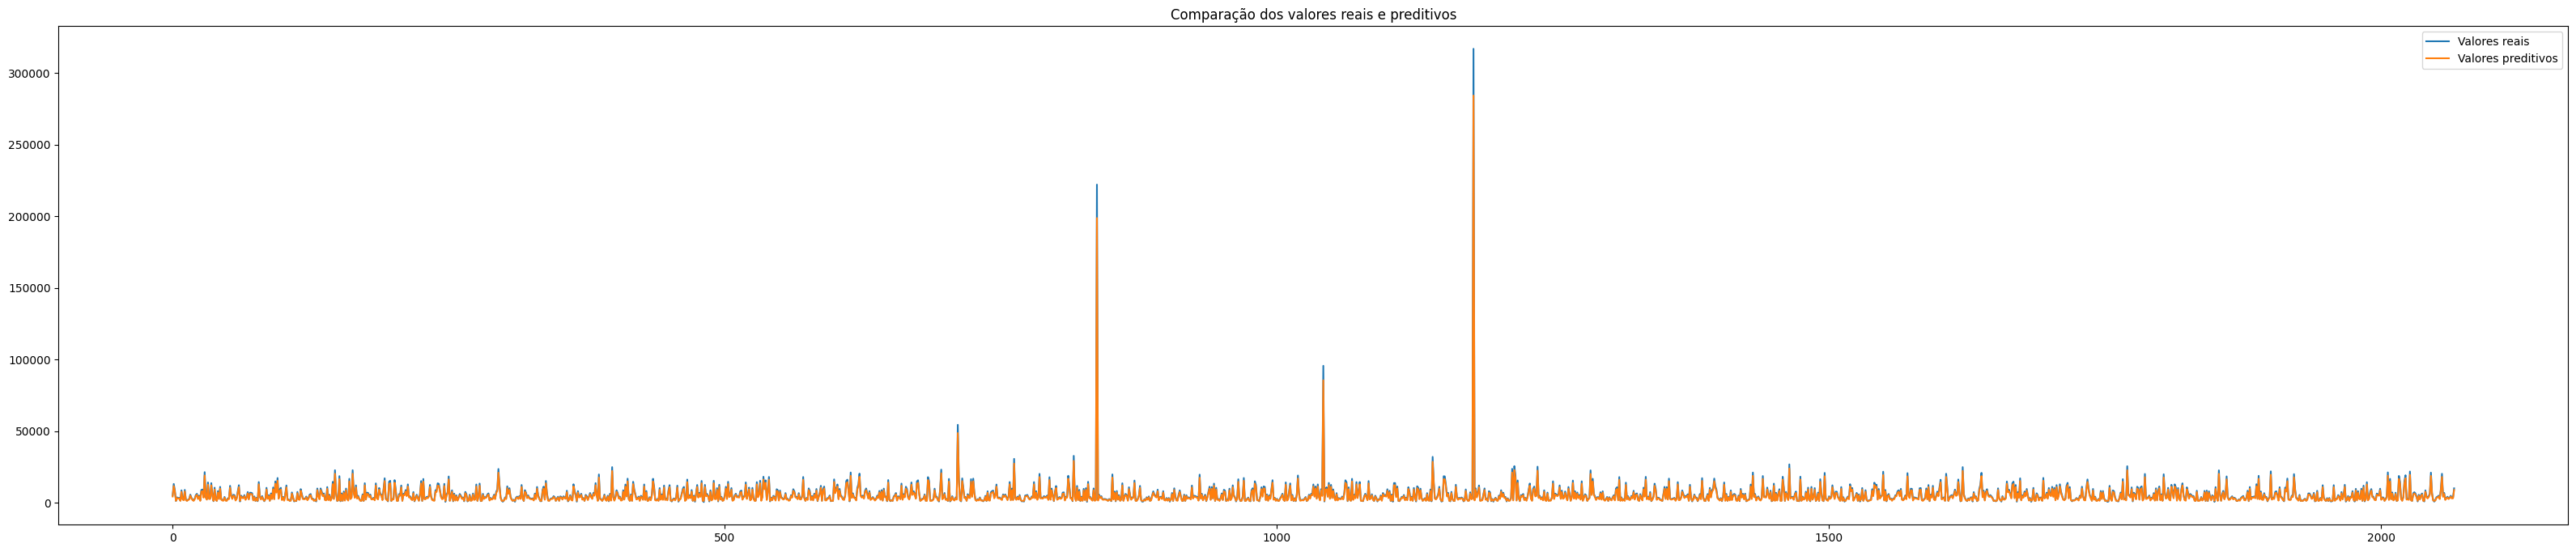

In [276]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred_keras, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();

In [ ]:
import joblib

In [277]:
joblib.dump(grid_kr, 'keras_modelo.pkl')

['keras_modelo.pkl']

In [ ]:
keras_modelo = joblib.load('keras_modelo.pkl')

# **No XGBoost a acurácia deu maior do que no Keras. XGBoost: 95%, Keras: 86,60%**